In [1]:
!pip install -q torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.3 MB/s eta 0:00:00


Preprocessing data with machine dependency features...
Building enhanced graph with machine dependencies...


<ipython-input-2-7421ef081c25>:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Timestamps'] = pd.to_datetime(df['Timestamps'])
<ipython-input-2-7421ef081c25>:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Visualizing graph structure...
Training model with machine-aware architecture...
Epoch 10/150, Loss: 0.638135
Current feature weights: [1.6939654 1.6940624 1.6939706 1.3066045 1.3066039 1.3066065 1.3067873
 1.306624  2.1193202]
Epoch 20/150, Loss: 0.317158
Current feature weights: [1.6852716 1.6854957 1.6852318 1.2988526 1.2988739 1.2988319 1.3012034
 1.2988645 2.110479 ]
Epoch 30/150, Loss: 0.269378
Current feature weights: [1.6762259 1.6768254 1.67635   1.2912238 1.2918888 1.2912431 1.2969657
 1.2908856 2.1012235]
Epoch 40/150, Loss: 0.255873
Current feature weights: [1.6674237 1.6683389 1.6675639 1.2839295 1.2858591 1.2839338 1.2930956
 1.283229  2.0923586]
Epoch 50/150, Loss: 0.245985
Current feature weights: [1.6604074 1.6616138 1.6606097 1.2782195 1.2812203 1.2781723 1.289886
 1.2772511 2.0854433]
Epoch 60/150, Loss: 0.229487
Current feature weights: [1.6560314 1.657424  1.6562508 1.2746176 1.2782567 1.2745388 1.2878015
 1.2736422 2.0810301]
Epoch 70/150, Loss: 0.235567
Current f

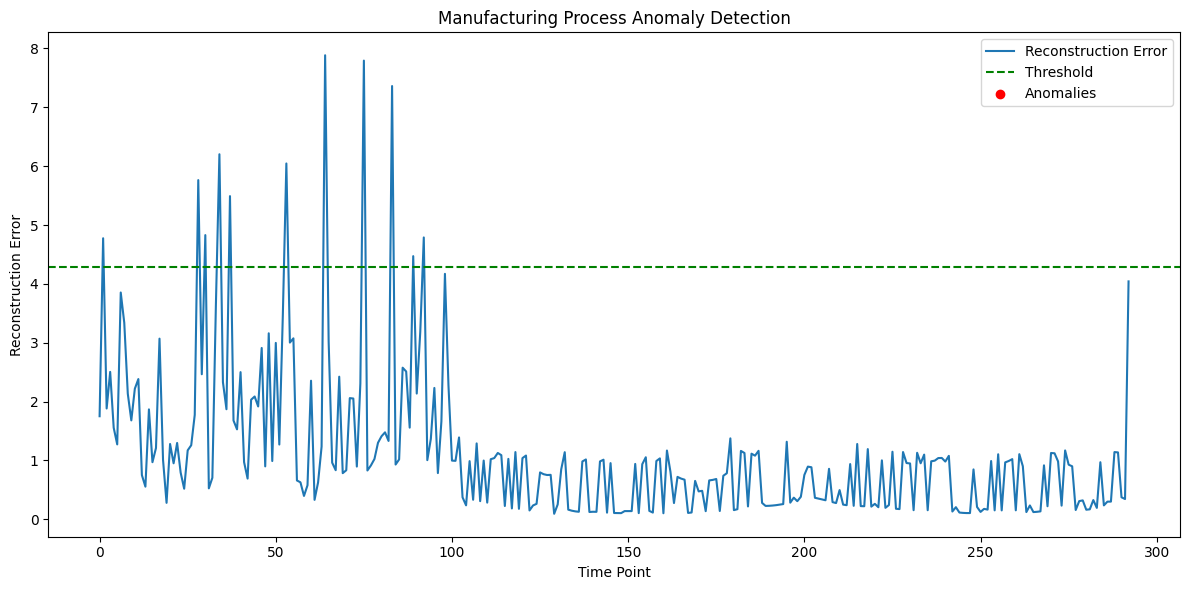

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import networkx as nx


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def preprocess_data(file_path):
    df = pd.read_csv(file_path)


    df['Timestamps'] = pd.to_datetime(df['Timestamps'])
    df['seconds_from_start'] = (df['Timestamps'] - df['Timestamps'].min()).dt.total_seconds()


    df.fillna(method='ffill', inplace=True)


    for machine in ['M1', 'M2', 'M3']:
        df[f'{machine}_Status_binary'] = (df[f'{machine}_Status'] == 'Running').astype(int)


    num_cols = [col for col in df.columns if 'Worker_Count' in col or 'seconds_from_start' in col]
    df[num_cols] = StandardScaler().fit_transform(df[num_cols])


    task_times = {
        1: (pd.to_datetime('17:58:07').time(), pd.to_datetime('17:59:47').time()),
        2: (pd.to_datetime('17:59:47').time(), pd.to_datetime('18:01:27').time()),
        3: (pd.to_datetime('18:01:27').time(), pd.to_datetime('18:02:59').time())
    }

    df['current_task'] = 0
    for task, (start, end) in task_times.items():
        df.loc[df['Timestamps'].dt.time.between(start, end, inclusive='both'), 'current_task'] = task


    df['time_in_current_task'] = 0.0
    for task in range(1, 4):
        mask = df['current_task'] == task
        if mask.any():
            task_start = df.loc[mask, 'seconds_from_start'].min()
            df.loc[mask, 'time_in_current_task'] = df.loc[mask, 'seconds_from_start'] - task_start


    df['task_machine_match'] = 0.0
    for i, row in df.iterrows():
        task = row['current_task']
        if task == 1 and row['M1_Status_binary'] == 1:
            df.at[i, 'task_machine_match'] = 1.0
        elif task == 2 and row['M2_Status_binary'] == 1:
            df.at[i, 'task_machine_match'] = 1.0
        elif task == 3 and row['M3_Status_binary'] == 1:
            df.at[i, 'task_machine_match'] = 1.0
        elif task == 1 and row['M1_Status_binary'] == 0 and row['M3_Status_binary'] == 1:
            df.at[i, 'task_machine_match'] = 0.5

    return df


def build_graph(df):

    features = df[[
        'M1_Status_binary', 'M2_Status_binary', 'M3_Status_binary',
        'M1_Worker_Count', 'M2_Worker_Count', 'M3_Worker_Count',
        'current_task', 'time_in_current_task', 'task_machine_match'
    ]].values


    node_features = torch.tensor(features, dtype=torch.float).to(device)


    num_nodes = len(df)
    edge_list = []


    task_indices = {}
    for task in range(4):
        task_indices[task] = df.index[df['current_task'] == task].tolist()


    for task, indices in task_indices.items():
        if len(indices) > 1:
            for i in range(len(indices)):

                if i > 0:
                    edge_list.append((indices[i-1], indices[i]))
                    edge_list.append((indices[i], indices[i-1]))

                if i < len(indices) - 1:
                    edge_list.append((indices[i], indices[i+1]))
                    edge_list.append((indices[i+1], indices[i]))


    machine_indices = {}
    for machine in ['M1', 'M2', 'M3']:
        machine_indices[machine] = df.index[df[f'{machine}_Status_binary'] == 1].tolist()

    for machine, indices in machine_indices.items():
        if len(indices) > 1:
            for i in range(len(indices)):
                for j in range(max(0, i-3), i):
                    if df.iloc[indices[i]]['current_task'] == df.iloc[indices[j]]['current_task']:
                        if abs(indices[i] - indices[j]) <= 10:
                            edge_list.append((indices[j], indices[i]))
                            edge_list.append((indices[i], indices[j]))


    if edge_list:
        edge_list = list(set(edge_list))
        edge_index = torch.tensor(edge_list, dtype=torch.long).t().to(device)
    else:
        edge_index = torch.stack([torch.arange(num_nodes), torch.arange(num_nodes)]).to(device)


    edge_weights = []
    for i in range(edge_index.shape[1]):
        source, target = edge_index[0, i].item(), edge_index[1, i].item()

        source_features = node_features[source]
        target_features = node_features[target]


        task_sim = 0.75


        machine_sim = sum([
            1 if source_features[j] == target_features[j] else 0
            for j in range(3)
        ]) / 3.0 * 0.25

        weight = task_sim + machine_sim
        edge_weights.append(weight)

    edge_weights = torch.tensor(edge_weights, dtype=torch.float).to(device)

    return Data(x=node_features, edge_index=edge_index, edge_attr=edge_weights)


class GNNAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, latent_dim=16, dropout=0.2):
        super(GNNAutoencoder, self).__init__()

        self.conv1 = GATConv(input_dim, hidden_dim, heads=4, dropout=dropout)
        self.conv2 = GATConv(hidden_dim*4, latent_dim, dropout=dropout)


        self.conv3 = GATConv(latent_dim, hidden_dim*4, dropout=dropout)
        self.conv4 = GATConv(hidden_dim*4, input_dim, dropout=dropout)

        self.dropout = nn.Dropout(dropout)


        self.feature_weights = nn.Parameter(torch.ones(input_dim))

        with torch.no_grad():
            self.feature_weights[:3] = 1.5
            self.feature_weights[-1] = 2.0

    def encode(self, x, edge_index, edge_attr=None):
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = self.dropout(x)
        z = self.conv2(x, edge_index, edge_attr)
        return z

    def decode(self, z, edge_index, edge_attr=None):
        x = F.elu(self.conv3(z, edge_index, edge_attr))
        x = self.dropout(x)
        x_hat = self.conv4(x, edge_index, edge_attr)
        return x_hat

    def forward(self, x, edge_index, edge_attr=None):
        z = self.encode(x, edge_index, edge_attr)
        x_hat = self.decode(z, edge_index, edge_attr)
        return x_hat, z

    def get_feature_weights(self):

        return F.softplus(self.feature_weights)

def train_model(model, data, epochs=100, lr=0.001, patience=15):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=5)

    model.train()
    losses = []
    best_loss = float('inf')
    no_improve = 0

    for epoch in range(epochs):
        optimizer.zero_grad()


        reconstructed, _ = model(data.x, data.edge_index, data.edge_attr)


        feature_weights = model.get_feature_weights()


        loss = torch.mean(feature_weights.unsqueeze(0) * (reconstructed - data.x)**2)


        weight_regularization = 0.01 * torch.sum((feature_weights - 1.0)**2)
        loss = loss + weight_regularization

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step(loss)

        losses.append(loss.item())


        if loss.item() < best_loss:
            best_loss = loss.item()
            no_improve = 0
        else:
            no_improve += 1

        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}')
            print(f'Current feature weights: {feature_weights.detach().cpu().numpy()}')

    return losses


def detect_anomalies(model, data, df):
    model.eval()

    with torch.no_grad():
        reconstructed, latent = model(data.x, data.edge_index, data.edge_attr)


        feature_weights = model.get_feature_weights()


        squared_errors = (data.x - reconstructed)**2
        weighted_errors = squared_errors * feature_weights.unsqueeze(0)
        errors = torch.sum(weighted_errors, dim=1).cpu().numpy()


        mean_error = np.mean(errors)
        std_error = np.std(errors)


        threshold = mean_error + 2.5 * std_error


        raw_anomalies = errors > threshold


        filtered_anomalies = apply_adaptive_rules(df, raw_anomalies, errors)


        print("Learned feature weights:")
        for i, weight in enumerate(feature_weights.cpu().numpy()):
            if i < 3:
                print(f"  M{i+1}_Status_binary: {weight:.3f}")
            elif i < 6:
                print(f"  M{i-2}_Worker_Count: {weight:.3f}")
            elif i == 6:
                print(f"  current_task: {weight:.3f}")
            elif i == 7:
                print(f"  time_in_current_task: {weight:.3f}")
            elif i == 8:
                print(f"  task_machine_match: {weight:.3f}")

        return filtered_anomalies, errors, threshold


def apply_adaptive_rules(df, anomalies, errors):
    filtered_anomalies = anomalies.copy()


    task_machine_requirements = {
        1: "M1",
        2: "M2",
        3: "M3"
    }


    for i in range(len(df)):
        if filtered_anomalies[i]:
            current_task = df.iloc[i]['current_task']


            if current_task not in task_machine_requirements:
                continue


            required_machine = task_machine_requirements[current_task]


            if df.iloc[i][f'{required_machine}_Status_binary'] == 1:
                filtered_anomalies[i] = False

            if i > 0 and df.iloc[i-1]['current_task'] == current_task:
                machine_changed = False
                for m in ['M1', 'M2', 'M3']:
                    if df.iloc[i][f'{m}_Status_binary'] != df.iloc[i-1][f'{m}_Status_binary']:
                        machine_changed = True
                        break

                if machine_changed:
                    filtered_anomalies[i] = False

    min_error_threshold = np.percentile(errors, 90)
    for i in range(len(filtered_anomalies)):
        if filtered_anomalies[i] and errors[i] < min_error_threshold:
            filtered_anomalies[i] = False

    return filtered_anomalies


def visualize_graph(data, df):

    G = nx.DiGraph()


    for i in range(data.x.shape[0]):
        task = df.iloc[i]['current_task']
        m1_status = df.iloc[i]['M1_Status_binary']
        m2_status = df.iloc[i]['M2_Status_binary']
        m3_status = df.iloc[i]['M3_Status_binary']


        if task == 1:
            color = 'blue'
        elif task == 2:
            color = 'green'
        elif task == 3:
            color = 'red'
        else:
            color = 'gray'


        if m1_status == 1:
            shape = 'o'
        elif m2_status == 1:
            shape = 's'
        elif m3_status == 1:
            shape = '^'
        else:
            shape = 'D'

        G.add_node(i, task=task, color=color, shape=shape,
                  m1=m1_status, m2=m2_status, m3=m3_status)


    edge_index = data.edge_index.cpu().numpy()
    for i in range(edge_index.shape[1]):
        src, dst = edge_index[0, i], edge_index[1, i]
        weight = data.edge_attr[i].item() if data.edge_attr is not None else 1.0
        G.add_edge(src.item(), dst.item(), weight=weight)


    if len(G) > 100:
        nodes = np.random.choice(list(G.nodes()), size=100, replace=False)
        G = G.subgraph(nodes)


    plt.figure(figsize=(12, 10))


    node_colors = [G.nodes[n]['color'] for n in G.nodes()]
    node_shapes = {}


    for shape in ['o', 's', '^', 'D']:
        nodelist = [n for n in G.nodes() if G.nodes[n]['shape'] == shape]
        if nodelist:
            nx.draw_networkx_nodes(G, pos=nx.spring_layout(G, seed=42),
                                 nodelist=nodelist,
                                 node_color=[G.nodes[n]['color'] for n in nodelist],
                                 node_shape=shape,
                                 node_size=100)


    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos=nx.spring_layout(G, seed=42),
                          alpha=0.5,
                          width=[w*0.5 for w in edge_weights])


    if len(G) <= 50:
        labels = {n: str(n) for n in G.nodes()}
        nx.draw_networkx_labels(G, pos=nx.spring_layout(G, seed=42), labels=labels, font_size=8)

    plt.title("Manufacturing Process Graph Structure")
    plt.savefig('manufacturing_graph.png')
    plt.close()


def detect_manufacturing_anomalies(file_path):

    print("Preprocessing data with machine dependency features...")
    df = preprocess_data(file_path)


    print("Building enhanced graph with machine dependencies...")
    data = build_graph(df)


    print("Visualizing graph structure...")
    visualize_graph(data, df)


    input_dim = data.x.shape[1]
    model = GNNAutoencoder(input_dim).to(device)


    print("Training model with machine-aware architecture...")
    losses = train_model(model, data, epochs=150, patience=20)


    print("Detecting anomalies with machine dependency consideration...")
    filtered_anomalies, errors, threshold = detect_anomalies(model, data, df)


    plt.figure(figsize=(12, 6))
    plt.plot(errors, label='Reconstruction Error')
    plt.axhline(y=threshold, color='green', linestyle='--', label='Threshold')

    plt.scatter(np.where(filtered_anomalies)[0], errors[filtered_anomalies],
               color='red', label='Anomalies')
    plt.title('Manufacturing Process Anomaly Detection')
    plt.xlabel('Time Point')
    plt.ylabel('Reconstruction Error')
    plt.legend()
    plt.tight_layout()
    plt.savefig('manufacturing_analysis.png')

    anomaly_df = df.copy()
    anomaly_df['reconstruction_error'] = errors
    anomaly_df['is_anomaly'] = filtered_anomalies
    anomaly_df.to_csv('manufacturing_analysis.csv', index=False)


    task_anomalies = {}
    for task in range(4):
        task_mask = df['current_task'] == task
        if task_mask.any():
            task_anomalies[task] = np.sum(filtered_anomalies & task_mask.values)

    print(f"Analysis complete. Found {np.sum(filtered_anomalies)} anomalies out of {len(df)} time points.")
    for task, count in task_anomalies.items():
        task_name = f"Task {task}" if task > 0 else "Idle/Setup"
        print(f"  - {task_name}: {count} anomalies")

    if np.sum(filtered_anomalies) == 0:
        print("No anomalies detected, which matches the expected outcome for this dataset.")

    return model, anomaly_df

if __name__ == "__main__":
    file_path = "manufacturing_test_data.csv"
    model, results = detect_manufacturing_anomalies(file_path)